
California House price prediction

In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.datasets import fetch_california_housing

warnings.filterwarnings("ignore")

In [2]:
housing = fetch_california_housing()
X = housing['data']
y = housing['target']

In [3]:
housing.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'feature_names', 'DESCR'])

In [4]:
print(housing.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

:Number of Instances: 20640

:Number of Attributes: 8 numeric, predictive attributes and the target

:Attribute Information:
    - MedInc        median income in block group
    - HouseAge      median house age in block group
    - AveRooms      average number of rooms per household
    - AveBedrms     average number of bedrooms per household
    - Population    block group population
    - AveOccup      average number of household members
    - Latitude      block group latitude
    - Longitude     block group longitude

:Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived from the 1990 U.S. census, using one row per ce

In [5]:
print(housing.data)

[[   8.3252       41.            6.98412698 ...    2.55555556
    37.88       -122.23      ]
 [   8.3014       21.            6.23813708 ...    2.10984183
    37.86       -122.22      ]
 [   7.2574       52.            8.28813559 ...    2.80225989
    37.85       -122.24      ]
 ...
 [   1.7          17.            5.20554273 ...    2.3256351
    39.43       -121.22      ]
 [   1.8672       18.            5.32951289 ...    2.12320917
    39.43       -121.32      ]
 [   2.3886       16.            5.25471698 ...    2.61698113
    39.37       -121.24      ]]


In [6]:
print(housing.target)

[4.526 3.585 3.521 ... 0.923 0.847 0.894]


In [7]:
print(housing.feature_names)

['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']


**Preparing dataset**

In [8]:
dataset = pd.DataFrame(housing.data,columns = housing.feature_names)

price attribute (the target )is missing in 'dataset'

In [10]:
dataset['Price'] = housing.target

In [11]:
dataset.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Price
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [12]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MedInc      20640 non-null  float64
 1   HouseAge    20640 non-null  float64
 2   AveRooms    20640 non-null  float64
 3   AveBedrms   20640 non-null  float64
 4   Population  20640 non-null  float64
 5   AveOccup    20640 non-null  float64
 6   Latitude    20640 non-null  float64
 7   Longitude   20640 non-null  float64
 8   Price       20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


Summarizing stats of data

In [13]:
dataset.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Price
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


In [14]:
dataset.isnull().sum()

MedInc        0
HouseAge      0
AveRooms      0
AveBedrms     0
Population    0
AveOccup      0
Latitude      0
Longitude     0
Price         0
dtype: int64

EDA

In [15]:
dataset.corr()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Price
MedInc,1.000000,-0.119034,0.326895,-0.062040,0.004834,0.018766,-0.079809,-0.015176,0.688075
HouseAge,-0.119034,1.000000,-0.153277,-0.077747,-0.296244,0.013191,0.011173,-0.108197,0.105623
AveRooms,0.326895,-0.153277,1.000000,0.847621,-0.072213,-0.004852,0.106389,-0.027540,0.151948
AveBedrms,-0.062040,-0.077747,0.847621,1.000000,-0.066197,-0.006181,0.069721,0.013344,-0.046701
Population,0.004834,-0.296244,-0.072213,-0.066197,1.000000,0.069863,-0.108785,0.099773,-0.024650
AveOccup,0.018766,0.013191,-0.004852,-0.006181,0.069863,1.000000,0.002366,0.002476,-0.023737
Latitude,-0.079809,0.011173,0.106389,0.069721,-0.108785,0.002366,1.000000,-0.924664,-0.144160
Longitude,-0.015176,-0.108197,-0.027540,0.013344,0.099773,0.002476,-0.924664,1.000000,-0.045967
Price,0.688075,0.105623,0.151948,-0.046701,-0.024650,-0.023737,-0.144160,-0.045967,1.000000


2 correlation checks:
- b/w independant and target
- b/w 2 indepandants

In [16]:
import seaborn as sns


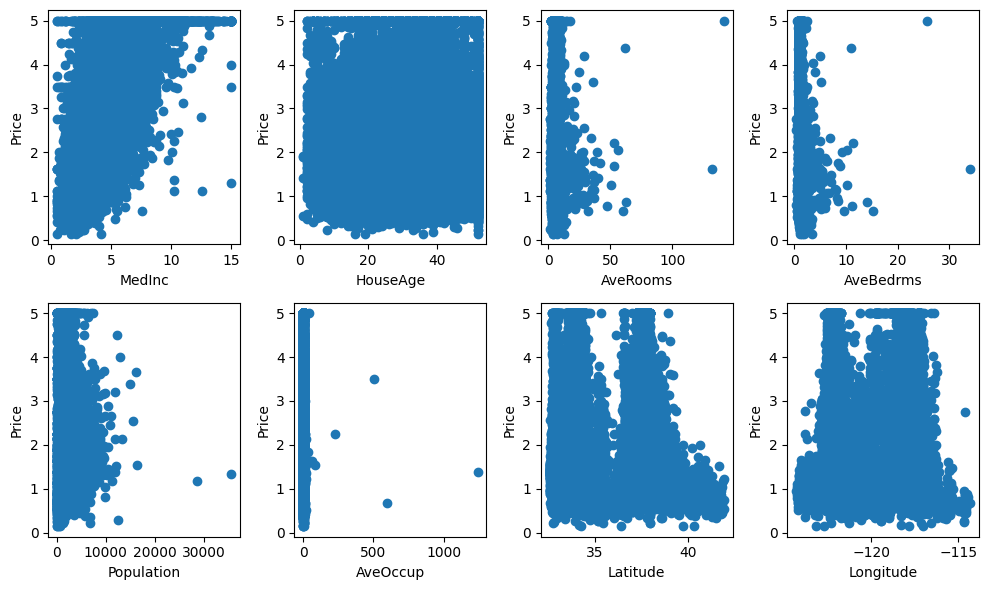

In [24]:
fig , axes = plt.subplots(2,4,figsize=(10,6))
axes = axes.flatten()
# 8 features
for i,feature in enumerate(housing.feature_names):
    axes[i].scatter(dataset[feature],dataset['Price'])
    #axes[i].set_title(feature + ' vs Price')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Price')
    
plt.tight_layout()
plt.show()


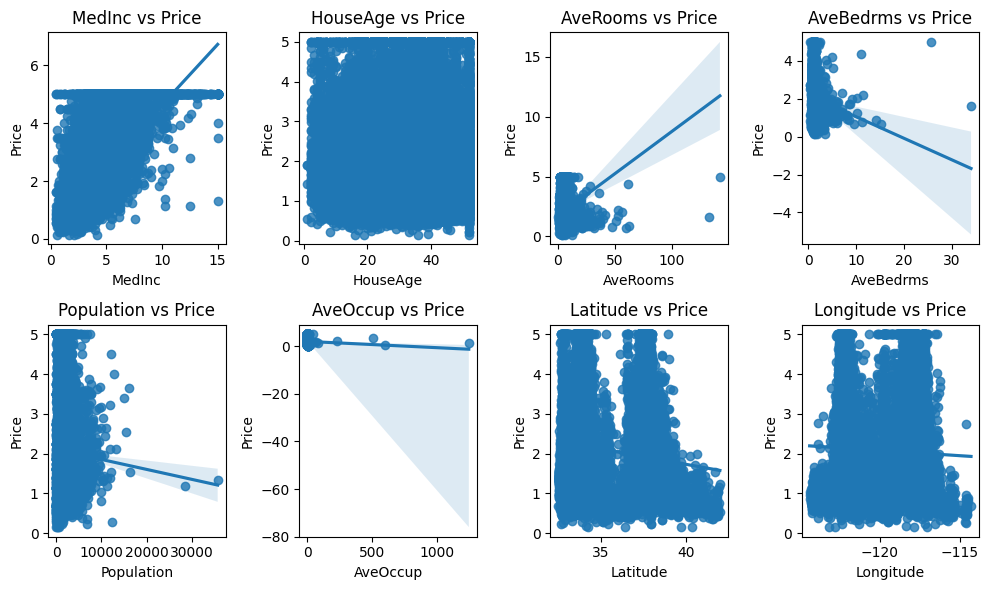

In [22]:
fig , axes = plt.subplots(2,4,figsize=(10,6))
axes = axes.flatten()
# 8 features
for i,feature in enumerate(housing.feature_names):
    sns.regplot(x=feature,y='Price',data=dataset,ax=axes[i])
    axes[i].set_title(feature + ' vs Price')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Price')
plt.tight_layout()
plt.show()


In [25]:
X=dataset.iloc[:,:-1]
y=dataset.iloc[:,-1]

In [26]:
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [27]:

y

0        4.526
1        3.585
2        3.521
3        3.413
4        3.422
         ...  
20635    0.781
20636    0.771
20637    0.923
20638    0.847
20639    0.894
Name: Price, Length: 20640, dtype: float64

Splitting dataset

In [28]:
from sklearn.model_selection import train_test_split as tts
X_train,X_test,y_train,y_test = tts(X,y,test_size=0.25,random_state=42)

In [29]:
X_train

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
8158,4.2143,37.0,5.288235,0.973529,860.0,2.529412,33.81,-118.12
18368,5.3468,42.0,6.364322,1.087940,957.0,2.404523,37.16,-121.98
19197,3.9191,36.0,6.110063,1.059748,711.0,2.235849,38.45,-122.69
3746,6.3703,32.0,6.000000,0.990196,1159.0,2.272549,34.16,-118.41
13073,2.3684,17.0,4.795858,1.035503,706.0,2.088757,38.57,-121.33
...,...,...,...,...,...,...,...,...
11284,6.3700,35.0,6.129032,0.926267,658.0,3.032258,33.78,-117.96
11964,3.0500,33.0,6.868597,1.269488,1753.0,3.904232,34.02,-117.43
5390,2.9344,36.0,3.986717,1.079696,1756.0,3.332068,34.03,-118.38
860,5.7192,15.0,6.395349,1.067979,1777.0,3.178891,37.58,-121.96


In [30]:

X_test

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
20046,1.6812,25.0,4.192201,1.022284,1392.0,3.877437,36.06,-119.01
3024,2.5313,30.0,5.039384,1.193493,1565.0,2.679795,35.14,-119.46
15663,3.4801,52.0,3.977155,1.185877,1310.0,1.360332,37.80,-122.44
20484,5.7376,17.0,6.163636,1.020202,1705.0,3.444444,34.28,-118.72
9814,3.7250,34.0,5.492991,1.028037,1063.0,2.483645,36.62,-121.93
...,...,...,...,...,...,...,...,...
5363,6.6260,51.0,5.532213,0.974790,771.0,2.159664,34.04,-118.42
19755,2.1898,30.0,4.509091,0.945455,410.0,2.484848,40.18,-122.21
4885,2.1667,37.0,3.272152,1.056962,2173.0,4.584388,34.02,-118.26
13043,6.8869,6.0,7.382385,1.030075,2354.0,2.528464,38.51,-121.06


Standardize the dataset

In [31]:
from sklearn.preprocessing import StandardScaler

In [32]:
scaler = StandardScaler()

In [33]:
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

In [35]:
X_train

array([[ 0.17648852,  0.66640687, -0.06085431, ..., -0.04828325,
        -0.8607415 ,  0.73099911],
       [ 0.77137436,  1.06288858,  0.38352076, ..., -0.05872947,
         0.70916822, -1.19670983],
       [ 0.02142423,  0.58711053,  0.27852339, ..., -0.07283798,
         1.31370062, -1.55128842],
       ...,
       [-0.49582442,  0.58711053, -0.5983225 , ...,  0.01885405,
        -0.75764295,  0.60115343],
       [ 0.96699069, -1.07811266,  0.39633361, ...,  0.0060417 ,
         0.90599273, -1.1867217 ],
       [-0.68434939,  1.855852  , -0.83954627, ..., -0.08347358,
         0.99503238, -1.41644868]])

In [36]:
X_test

array([[-1.15411223, -0.28514924, -0.51346718, ...,  0.06447083,
         0.19367548,  0.28652736],
       [-0.70756701,  0.11133247, -0.16361884, ..., -0.03570466,
        -0.23746391,  0.06179445],
       [-0.20917611,  1.855852  , -0.6022714 , ..., -0.14606959,
         1.00909127, -1.4264368 ],
       ...,
       [-0.89908611,  0.66640687, -0.89340574, ...,  0.12360294,
        -0.76232924,  0.66108221],
       [ 1.58036659, -1.79177974,  0.80393479, ..., -0.04836253,
         1.34181841, -0.73725589],
       [ 1.44652384,  0.58711053,  0.12349223, ..., -0.04755791,
        -0.82325111,  0.5911653 ]])

Saving the scaler

In [37]:
import pickle
pickle.dump(scaler,open('scaling.pkl','wb'))

Model Training

In [38]:
from sklearn.linear_model import LinearRegression

In [39]:
regression=LinearRegression()

In [41]:
regression.fit(X_train,y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


Coefficients and intercept/bias

In [42]:
print(regression.coef_)

[ 0.85210815  0.12065533 -0.30210555  0.34860575 -0.00164465 -0.04116356
 -0.89314697 -0.86784046]


In [43]:
print(regression.intercept_)

2.0703489205426377


In [44]:
## on which parameters the model has been trained
regression.get_params()

{'copy_X': True,
 'fit_intercept': True,
 'n_jobs': None,
 'positive': False,
 'tol': 1e-06}

Prediction with test data

In [45]:
reg_pred=regression.predict(X_test)

In [46]:
reg_pred

array([0.72412832, 1.76677807, 2.71151581, ..., 1.72382152, 2.34689276,
       3.52917352])

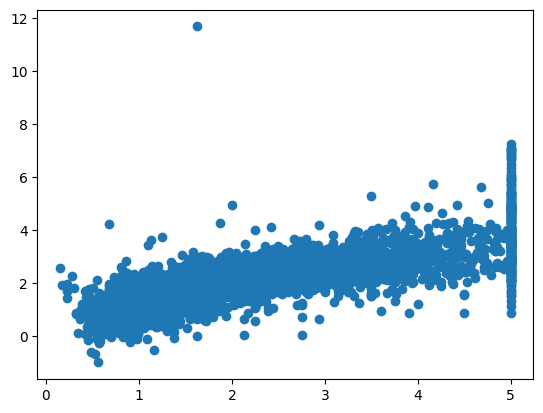

In [47]:
plt.scatter(y_test,reg_pred)

Residuals

In [48]:
residuals=y_test-reg_pred

In [49]:
residuals

20046   -0.247128
3024    -1.308778
15663    2.288494
20484   -0.650012
9814     0.176245
           ...   
5363     1.422160
19755    0.064301
4885    -0.546822
13043    0.284107
8583     1.285826
Name: Price, Length: 5160, dtype: float64

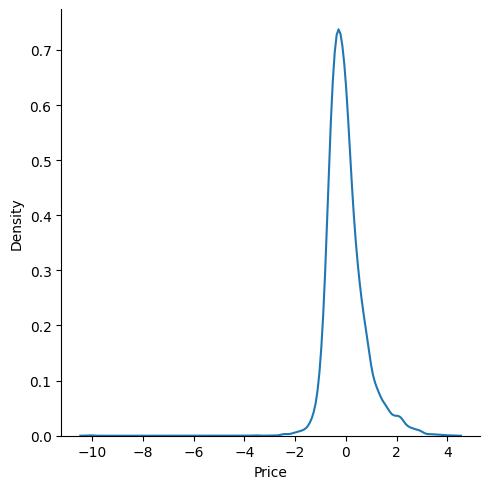

In [50]:
sns.displot(residuals,kind="kde")

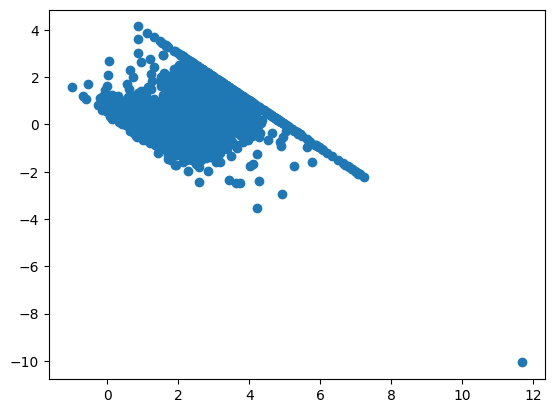

In [51]:
plt.scatter(reg_pred,residuals)

losses / errors

In [52]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

print(mean_absolute_error(y_test,reg_pred))
print(mean_squared_error(y_test,reg_pred))
print(np.sqrt(mean_squared_error(y_test,reg_pred)))

0.5296964012919461
0.5411287478470689
0.7356145375446769


R square and adjusted R square

*R^2 = 1 - SSR/SST*;
where SSR = sum of squares of residuals AND SST = Total sum of squares 

In [53]:
from sklearn.metrics import r2_score
score=r2_score(y_test,reg_pred)
print(score)

0.5910509795491351


Adjusted R2 = 1 – [(1-R2)*(n-1)/(n-k-1)];
where 

n: The number of observations , k: The number of predictor variables

In [54]:
1 - (1-score)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)

0.590415842262471

New data prediction

In [68]:
new_sample = housing.data[0].reshape(1,-1)

In [69]:
new_sample

array([[   8.3252    ,   41.        ,    6.98412698,    1.02380952,
         322.        ,    2.55555556,   37.88      , -122.23      ]])

In [78]:
scaler.transform(new_sample)

array([[ 2.33588475,  0.98359224,  0.6394724 , -0.16653   , -0.96727898,
        -0.04609648,  1.04658166, -1.32156145]])

In [79]:
regression.predict(scaler.transform(new_sample))

array([4.1438511])

Saving the model

In [72]:
pickle.dump(regression,open('regmodel.pkl','wb'))

In [73]:
pickled_model=pickle.load(open('regmodel.pkl','rb'))

test with 10th sample

In [80]:
pickled_model.predict(scaler.transform(housing.data[10].reshape(1,-1)))

array([2.21443142])